In [1]:
from msmbuilder.dataset import dataset
import os
import mdtraj as mdt
import glob


cwd = os.getcwd()
print(cwd)

## Load
xyz = dataset("*SC*.xtc", topology="md.loop_SC_start.gro")
    
for traj in xyz:
    print(traj)

/Users/sbamos/Documents/WORK/MSM
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>
<mdtraj.Trajectory with 5001 frames, 447 atoms, 41 residues, and unitcells>


# Load Data

In [2]:
print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 0.1
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

5 trajectories
with length {500.1} ns


# Featurisation

In [3]:
from  msmbuilder.featurizer  import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = featurizer.fit_transform(xyz)

print(xyz[0].xyz.shape)
print(diheds[0].shape)

(5001, 447, 3)
(5001, 160)


# Preprocessing

In [4]:
from  msmbuilder.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_diheds = scaler.fit_transform(diheds)

print(diheds[0].shape)
print(scaled_diheds[0].shape)

/Users/sbamos/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/sbamos/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


(5001, 160)
(5001, 160)


# tICA

In [5]:
from  msmbuilder.decomposition  import tICA
tica_model = tICA(lag_time=2, n_components=4)
# fit and transform can be done in seperate steps:
tica_model.fit(diheds)
tica_trajs = tica_model.fit_transform(diheds)

print(diheds[0].shape)
print(tica_trajs[0].shape)

(5001, 160)
(5001, 4)


# Histogram the data

/Users/sbamos/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


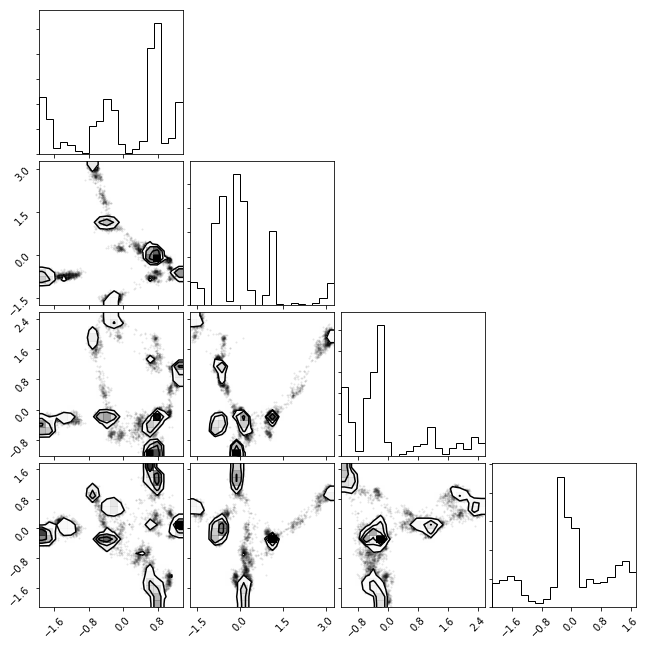

In [6]:
%matplotlib inline
import msmexplorer as msme
import numpy as np
txx = np.concatenate(tica_trajs)
_ = msme.plot_histogram(txx)

In [7]:
## Clustering

In [58]:
from msmbuilder.cluster import MiniBatchKMeans
clusterer = MiniBatchKMeans(n_clusters=3, random_state=42)
clustered_trajs = clusterer.fit_transform(tica_trajs)

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(5001, 4)
(5001,)


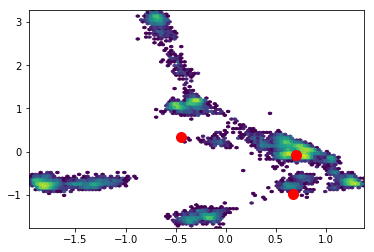

In [59]:
from matplotlib import pyplot as plt
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='r')

# MSM

In [66]:
from  msmbuilder.msm import MarkovStateModel
msm = MarkovStateModel(lag_time=10, n_timescales=5)
msm.fit(clustered_trajs)


MSM contains 1 strongly connected component above weight=0.10. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=10, n_timescales=5,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

(25005, 3)


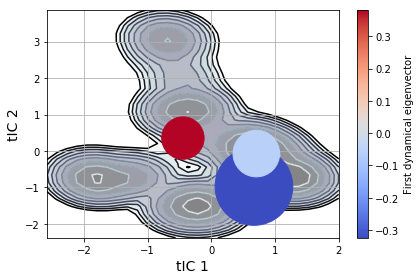

In [67]:
assignments = clusterer.partial_transform(txx)
assignments = msm.partial_transform(assignments)

state_pop = msm.countsmat_[np.concatenate(assignments)]

print(np.shape(state_pop))


msme.plot_free_energy(txx, obs=(0, 1,), n_samples=10000,
            pi=msm.populations_[np.concatenate(assignments, axis=0)],
            xlabel='tIC 1', ylabel='tIC 2')



plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm",
            zorder=3) 
plt.colorbar(label='First dynamical eigenvector')
plt.tight_layout()

In [68]:
msm.timescales_

array([ 19014.43172983,   2339.02053959])

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/msm/msm.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma2)


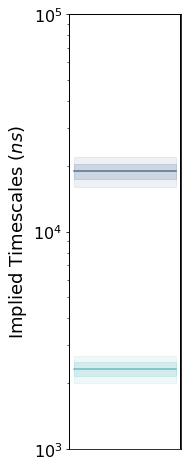

In [69]:
msme.plot_timescales(msm, n_timescales=5,
                     ylabel='Implied Timescales ($ns$)')

# Microstate model

In [70]:
from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
macro_trajs = pcca.transform(clustered_trajs)

Optimization terminated successfully.
         Current function value: -2.995208
         Iterations: 9
         Function evaluations: 53


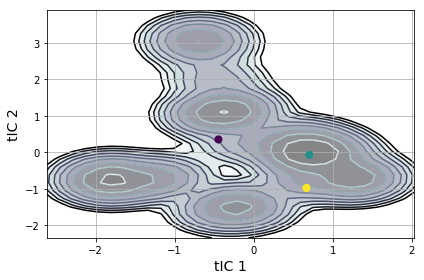

In [71]:
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
#                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=50,
            c=pcca.microstate_mapping_,
            zorder=3
           )
plt.tight_layout()